In [1]:
import json
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open("../results/distances.json", "r") as f:
    distances = json.load(f)

In [3]:
distances = {tuple(k.split("_")): v for k,v in distances.items()}

In [4]:
cwes = set([k[0] for k in distances.keys()] + [k[1] for k in distances.keys()])
sorted_cwes = list(sorted(cwes, key=lambda k: int(k.split("-")[-1])))

In [5]:
def sinkhorn(P):
    # from: https://github.com/btaba/sinkhorn_knopp/blob/73e9d74e7f050d0d08e00957ab3f3f2fbc2d25f2/sinkhorn_knopp/sinkhorn_knopp.py#L90
    _epsilon = 1e-3
    _max_iter = 1000
    P = np.asarray(P)
    assert np.all(P >= 0)
    assert P.ndim == 2
    assert P.shape[0] == P.shape[1]

    N = P.shape[0]
    max_thresh = 1 + _epsilon
    min_thresh = 1 - _epsilon

    # Initialize r and c, the diagonals of D1 and D2
    # and warn if the matrix does not have support.
    r = np.ones((N, 1))
    pdotr = P.T.dot(r)
    total_support_warning_str = (
        "Matrix P must have total support. "
        "See documentation"
    )
    if not np.all(pdotr != 0):
        print(total_support_warning_str)

    c = 1 / pdotr
    pdotc = P.dot(c)
    if not np.all(pdotc != 0):
        print(total_support_warning_str)

    r = 1 / pdotc
    del pdotr, pdotc

    P_eps = np.copy(P)
    _D1, _D2 = np.ones(1), np.ones(1)
    _iterations = 0
    while np.any(np.sum(P_eps, axis=1) < min_thresh) \
            or np.any(np.sum(P_eps, axis=1) > max_thresh) \
            or np.any(np.sum(P_eps, axis=0) < min_thresh) \
            or np.any(np.sum(P_eps, axis=0) > max_thresh):

        c = 1 / P.T.dot(r)
        r = 1 / P.dot(c)

        _D1 = np.diag(np.squeeze(r))
        _D2 = np.diag(np.squeeze(c))
        P_eps = _D1.dot(P).dot(_D2)

        _iterations += 1

        if _iterations >= _max_iter:
            break

    _D1 = np.diag(np.squeeze(r))
    _D2 = np.diag(np.squeeze(c))
    P_eps = _D1.dot(P).dot(_D2)

    return P_eps

In [6]:
distance_matrix = np.asarray([[distances[(cwe1, cwe2)] for cwe1 in sorted_cwes] for cwe2 in sorted_cwes])
distance_matrix = sinkhorn(distance_matrix)
normalized_distances = {(cwe1, cwe2): distance_matrix[i,j] for i, cwe2 in enumerate(sorted_cwes) for j, cwe1 in enumerate(sorted_cwes)}

In [16]:
normalized_distances = {}
mean_distances = {}
for cwe in sorted_cwes:
    mean_distances[cwe] = sum(distances[(cwe, cwe_)] for cwe_ in sorted_cwes) / len(sorted_cwes)
for cwe1 in sorted_cwes:
    for cwe2 in sorted_cwes:
        intra1 = distances[(cwe1, cwe1)]
        intra2 = distances[(cwe2, cwe2)]
        inter = distances[(cwe1, cwe2)]
        normalized_distances[(cwe1, cwe2)] = inter / (math.sqrt(mean_distances[cwe1]) * math.sqrt(mean_distances[cwe2]))
for cwe1 in sorted_cwes:
    for cwe2 in sorted_cwes:
        if cwe1 == cwe2:
            continue
        intra1 = normalized_distances[(cwe1, cwe1)]
        intra2 = normalized_distances[(cwe2, cwe2)]
        inter = normalized_distances[(cwe1, cwe2)]
        normalized_distances[(cwe1, cwe2)] = inter - intra1
for cwe in sorted_cwes:
    normalized_distances[(cwe, cwe)] = 0.0

In [7]:
def plot_cwe(cwe):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(sorted_cwes, [normalized_distances[(cwe, cwe_)] for cwe_ in sorted_cwes])
    ax.set_xticks(
        ax.get_xticks(),
        ax.get_xticklabels(),
        rotation=90,
        horizontalalignment='right'
    )
    ax.axhline(normalized_distances[(cwe, cwe)], color="r")

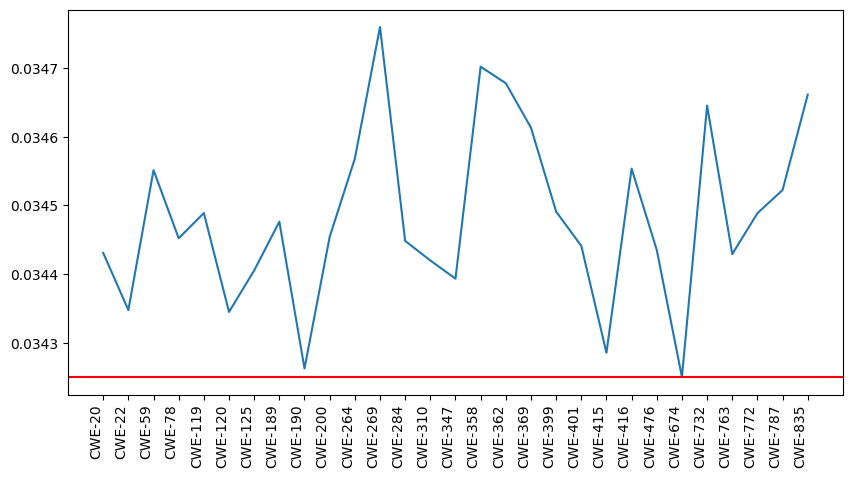

In [8]:
plot_cwe("CWE-674")

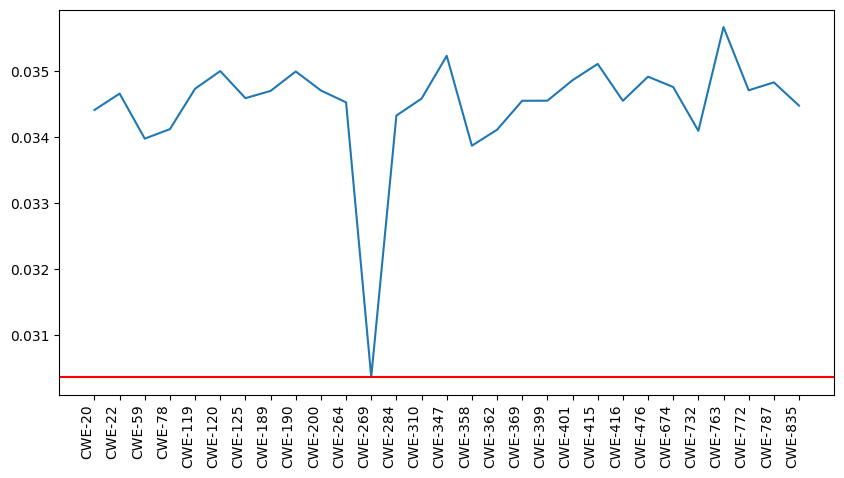

In [9]:
plot_cwe("CWE-269")

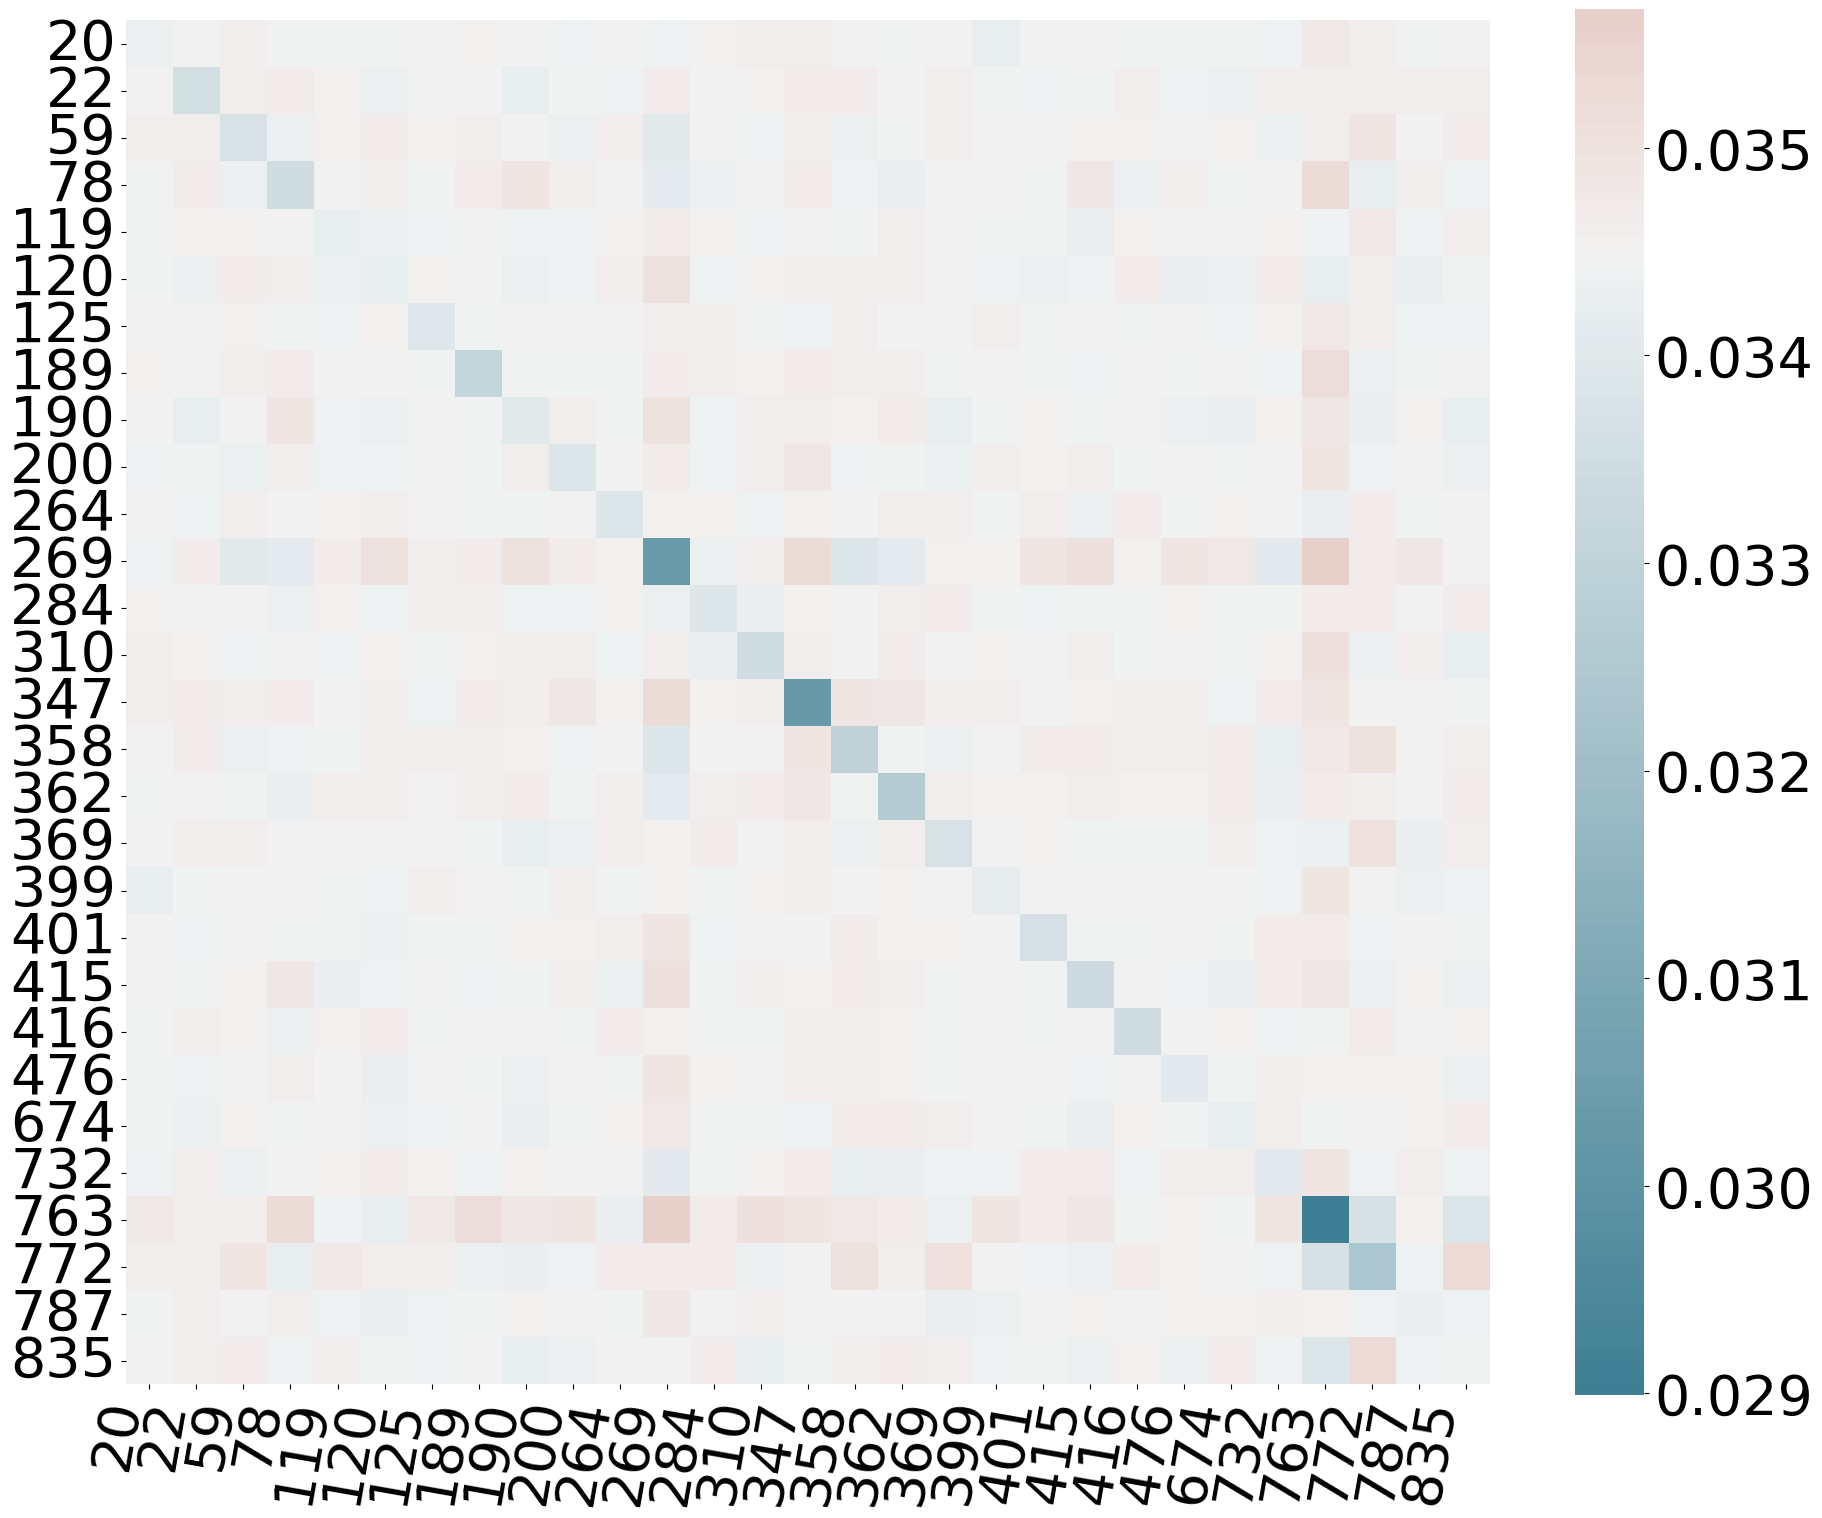

In [10]:
distances_arr = [[normalized_distances[(cwe1, cwe2)] for cwe2 in sorted_cwes] for cwe1 in sorted_cwes]

plt.rc("xtick", labelsize=40)
plt.rc("ytick", labelsize=40)
fig, ax = plt.subplots(figsize=(22,18))
sns.heatmap(
    distances_arr,
    xticklabels=[s.replace("CWE-", "") for s in sorted_cwes],
    yticklabels=[s.replace("CWE-", "") for s in sorted_cwes],
    cmap=sns.diverging_palette(220, 20, n=200),
    center=1/len(sorted_cwes),
    square=True,
    ax=ax
)
ax.set_xticks(
    ax.get_xticks(),
    ax.get_xticklabels(),
    rotation=80,
    horizontalalignment="right"
)
plt.savefig("../results/distances.pdf")
None # disable printing of ticks

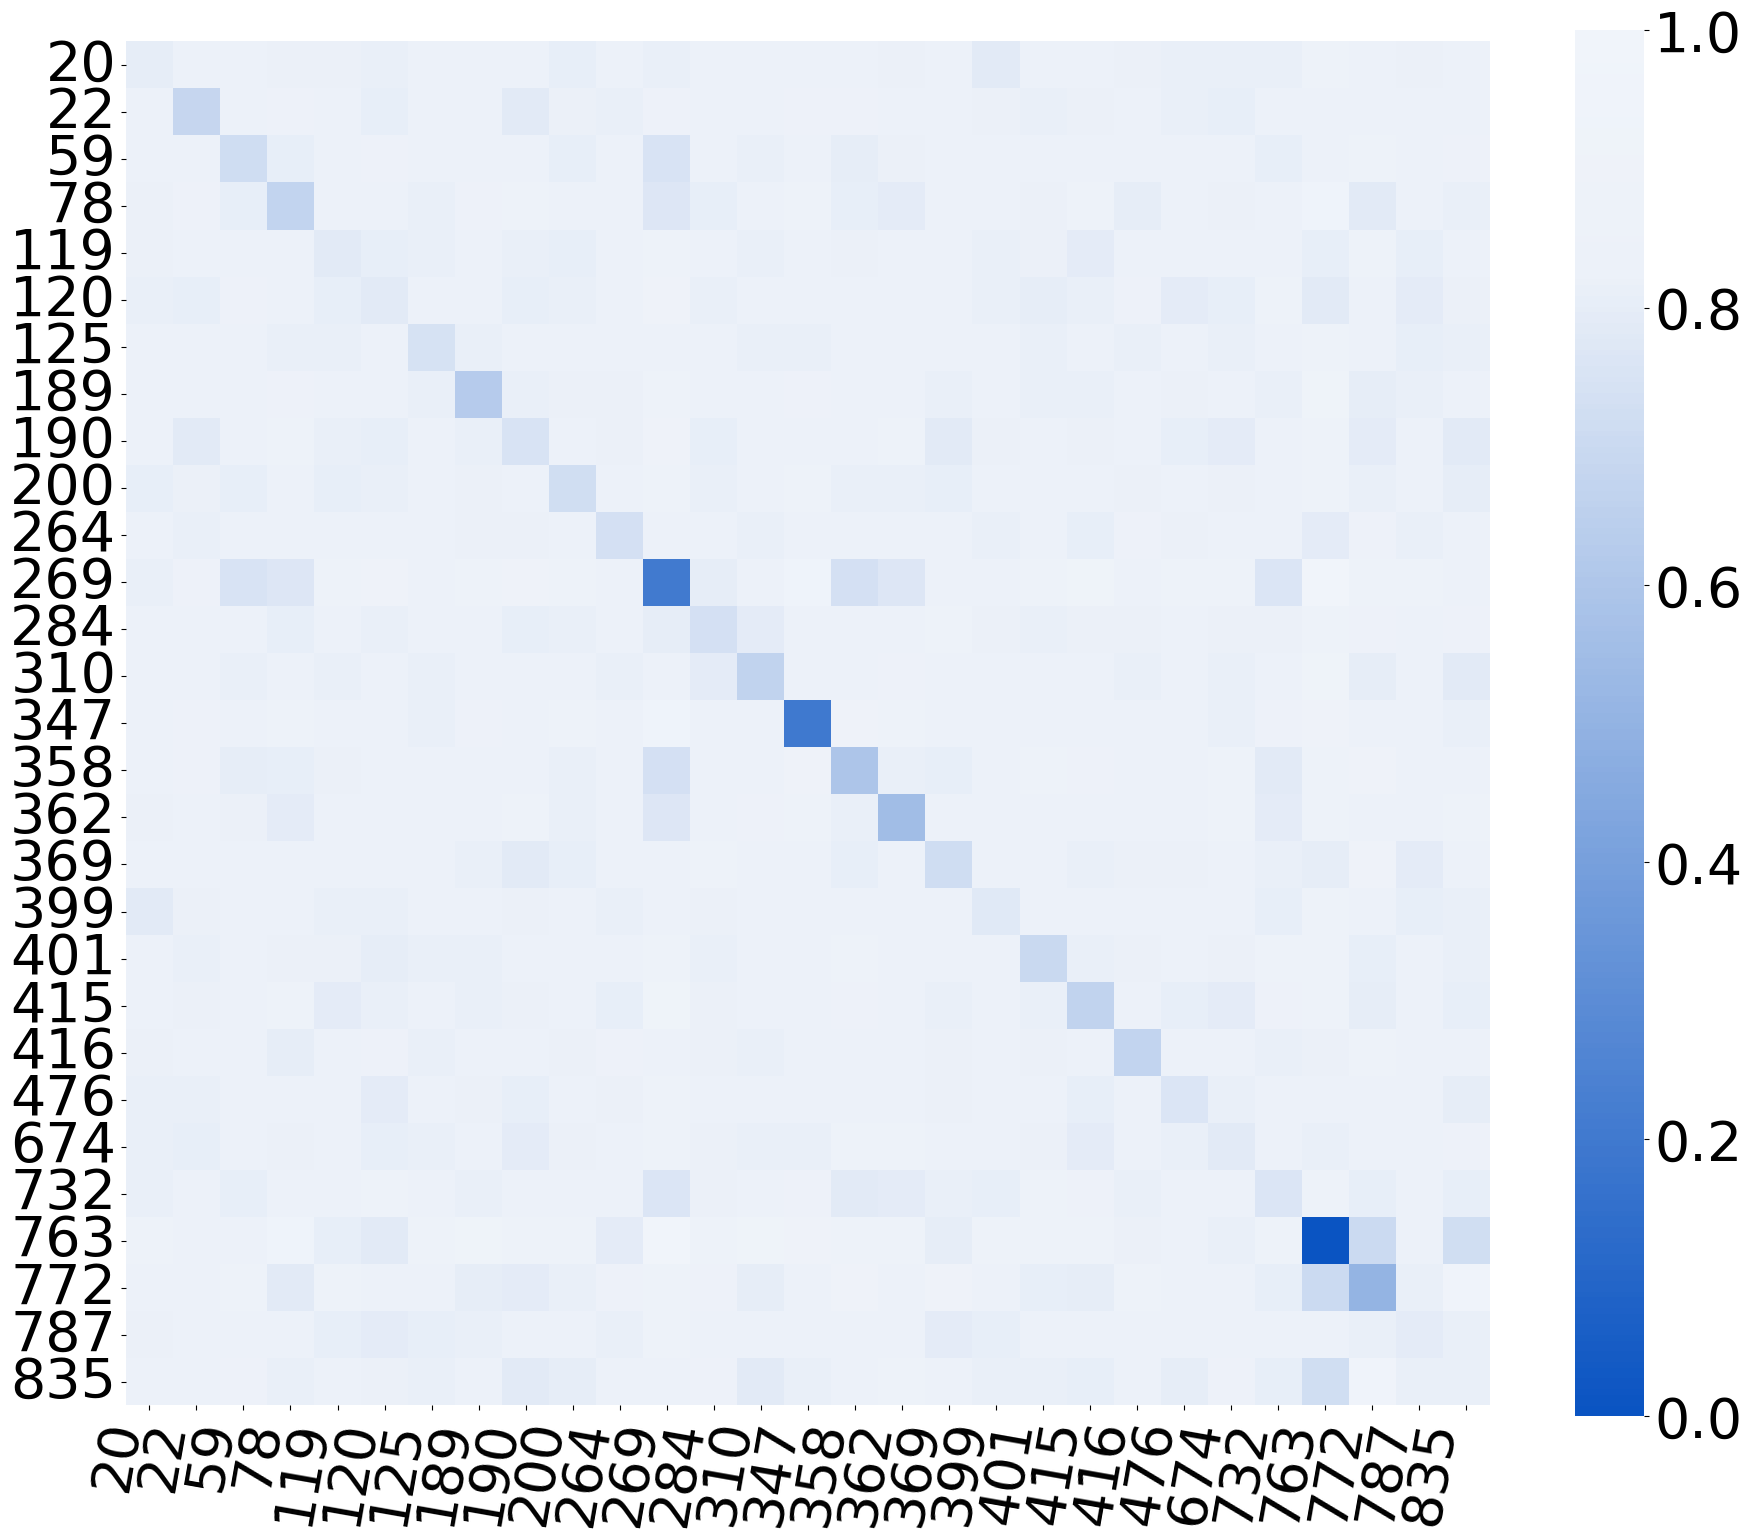

In [12]:
max_distance = max(normalized_distances.values())
min_distance = min(normalized_distances.values())
distances_arr = [[(normalized_distances[(cwe1, cwe2)] - min_distance)/(max_distance - min_distance) for cwe2 in sorted_cwes] for cwe1 in sorted_cwes]

plt.rc("xtick", labelsize=40)
plt.rc("ytick", labelsize=40)
fig, ax = plt.subplots(figsize=(22,18))
sns.heatmap(
    distances_arr,
    xticklabels=[s.replace("CWE-", "") for s in sorted_cwes],
    yticklabels=[s.replace("CWE-", "") for s in sorted_cwes],
    # cmap=sns.diverging_palette(220, 20, n=200),
    cmap=sns.blend_palette([(2.6, 0.4, 0.9), (2.6, 0.95, 0.5), (2.6, 1, 0.5)], input="hls", n_colors=256),
    center=(1/len(sorted_cwes)-min_distance)/(max_distance-min_distance),
    vmin=0,
    vmax=1,
    square=True,
    ax=ax
)
ax.set_xticks(
    ax.get_xticks(),
    ax.get_xticklabels(),
    rotation=80,
    horizontalalignment="right"
)
plt.savefig("../results/distances.pdf", bbox_inches="tight")